In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ipshasinha01","key":"9d82202f6538423144ead00dc4e82bb9"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d emmarex/plantdisease

Dataset URL: https://www.kaggle.com/datasets/emmarex/plantdisease
License(s): unknown


In [ ]:
import zipfile

zip_data = zipfile.ZipFile('/content/plantdisease.zip')
zip_data.extractall()
zip_data.close()

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import pandas as pd
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import shutil

In [ ]:
folder_path = "/content/plantvillage"

shutil.rmtree(folder_path)


**Image Preprocessing**

  * **Resizing & Cropping**:Standardize images to a fixed input size for the model.

  * **Normalization**: Scale pixel values between 0 and 1 for stable training.

  * **Color Handling**: Convert grayscale images to RGB (if needed) to match model expectations.

* **Data Cleaning**: Remove noisy or corrupted images from the dataset.







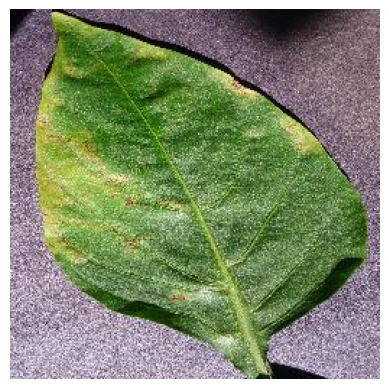

In [ ]:
img = cv2.imread('/content/PlantVillage/Pepper__bell___Bacterial_spot/01613cd0-d3cd-4e96-945c-a312002037bf___JR_B.Spot 3262.JPG')

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img_rgb)
plt.axis("off")
plt.show()

In [ ]:
import os

# Path to the main folder (change it as needed)
main_folder = "/content/PlantVillage"

# List all subdirectories
subfolders = [f.name for f in os.scandir(main_folder) if f.is_dir()]

print("📂 Subfolder Names:", subfolders)

📂 Subfolder Names: ['Tomato_Early_blight', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Tomato_healthy', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato_Leaf_Mold', 'Tomato_Bacterial_spot', 'Tomato__Target_Spot', 'Pepper__bell___Bacterial_spot', 'Tomato_Late_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato__Tomato_mosaic_virus', 'Tomato_Septoria_leaf_spot']


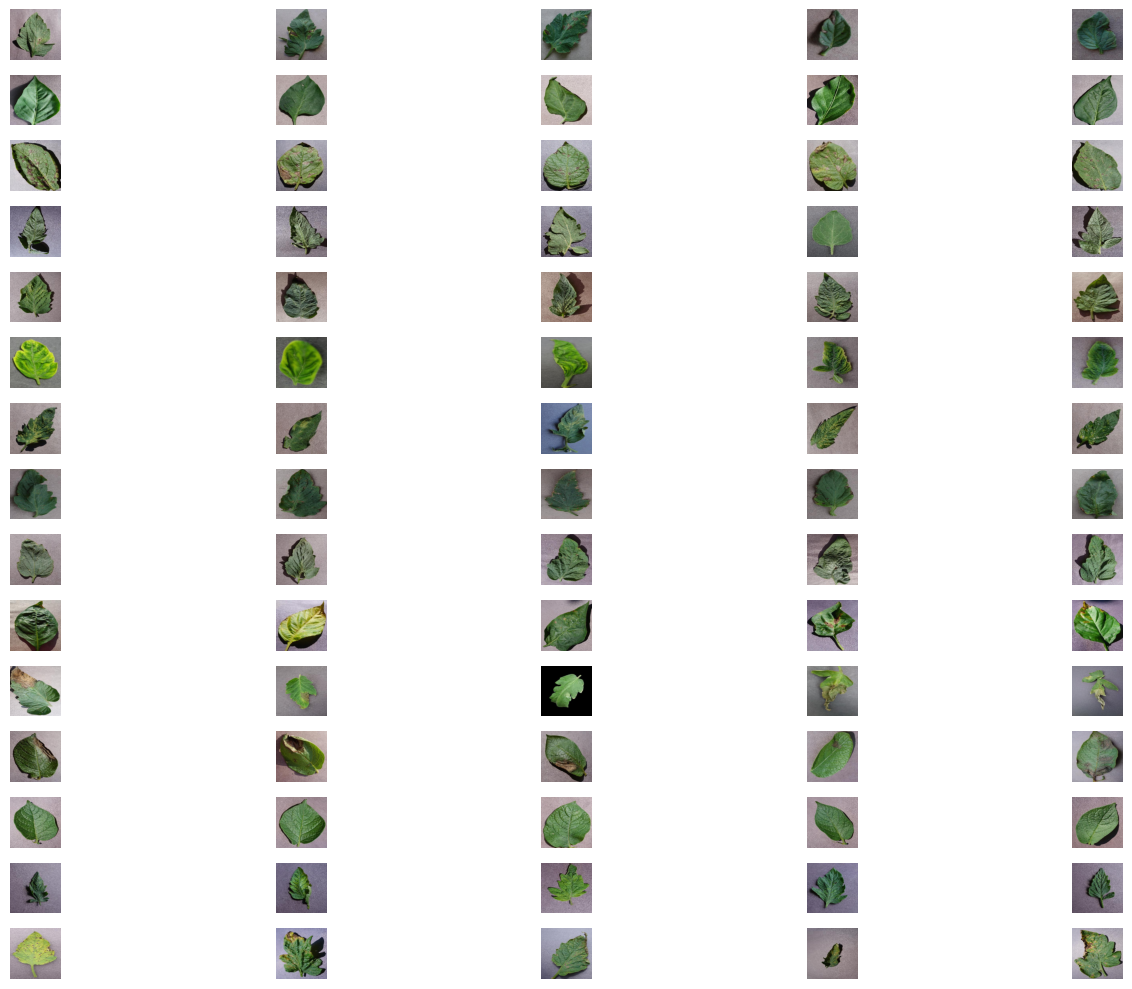

In [ ]:
import os
import random
import matplotlib.pyplot as plt
import cv2

def visualize_samples(dataset_path, num_samples=5):
    classes = os.listdir(dataset_path)
    fig, axes = plt.subplots(len(classes), num_samples, figsize=(15, 10))

    for i, class_name in enumerate(classes):
        class_path = os.path.join(dataset_path, class_name)
        images = os.listdir(class_path)
        random_images = random.sample(images, min(num_samples, len(images)))

        for j, img_name in enumerate(random_images):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            axes[i, j].imshow(img)
            axes[i, j].axis("off")

        axes[i, 0].set_ylabel(class_name, fontsize=10)

    plt.tight_layout()
    plt.show()

# Call function with dataset path
visualize_samples("/content/PlantVillage")

In [ ]:
def detect_blur(image_path, threshold=100):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    laplacian_var = cv2.Laplacian(image, cv2.CV_64F).var()

    if laplacian_var < threshold:
        print(f"⚠ Blurry Image Detected: {image_path} (Variance: {laplacian_var:.2f})")
    return laplacian_var

# Example usage
image_path = "/content/PlantVillage/Tomato__Target_Spot/002213fb-b620-4593-b9ac-6a6cc119b100___Com.G_TgS_FL 8360.JPG"
blur_score = detect_blur(image_path)
print(f"Laplacian Variance Score: {blur_score:.2f}")

Laplacian Variance Score: 7044.20


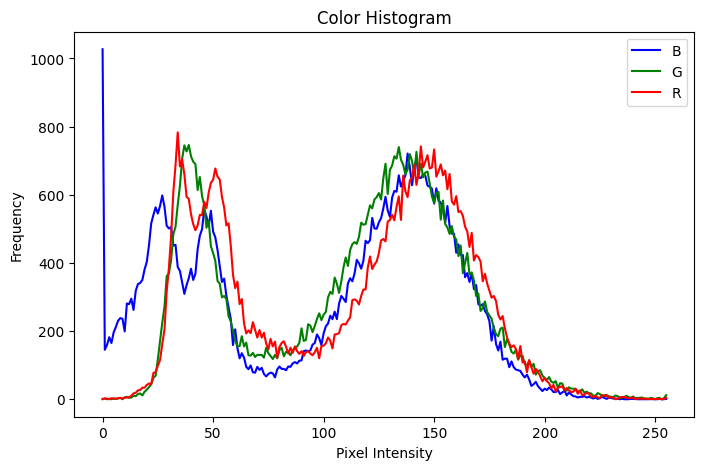

In [ ]:
def plot_color_histogram(image_path):
    image = cv2.imread(image_path)
    channels = ('b', 'g', 'r')
    plt.figure(figsize=(8, 5))

    for i, col in enumerate(channels):
        hist = cv2.calcHist([image], [i], None, [256], [0, 256])
        plt.plot(hist, color=col, label=col.upper())

    plt.title("Color Histogram")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

# Example usage
plot_color_histogram("/content/PlantVillage/Tomato__Target_Spot/002213fb-b620-4593-b9ac-6a6cc119b100___Com.G_TgS_FL 8360.JPG")

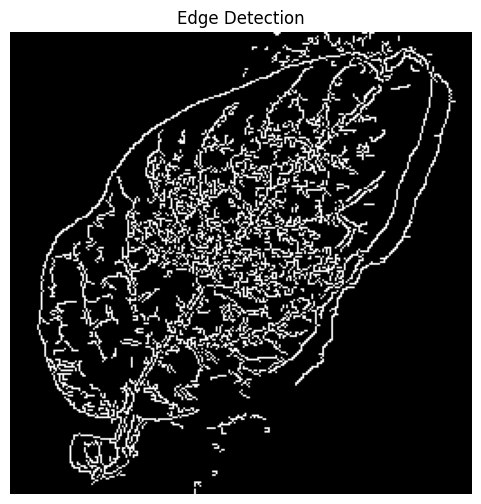

In [ ]:

def edge_detection(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    edges = cv2.Canny(image, 100, 200)

    plt.figure(figsize=(6, 6))
    plt.imshow(edges, cmap='gray')
    plt.title("Edge Detection")
    plt.axis("off")
    plt.show()

# Example usage
edge_detection("/content/PlantVillage/Potato___Late_blight/006cc01a-1888-4326-9b62-a65cb55a6377___RS_LB 5207.JPG")

In [ ]:
import os

dataset_path = "/content/PlantVillage"
categories = [
    'Tomato_Septoria_leaf_spot', 'Potato___Early_blight', 'Pepper__bell___healthy',
    'Tomato_healthy', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus',
    'Tomato_Late_blight', 'Tomato_Early_blight', 'Potato___healthy', 'Pepper__bell___Bacterial_spot',
    'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato_Bacterial_spot',
    'Potato___Late_blight', 'Tomato_Leaf_Mold'
]

for category in categories:
    class_path = os.path.join(dataset_path, category)

    # Count only image files (not folders)
    if os.path.exists(class_path) and os.path.isdir(class_path):
        image_count = sum(1 for file in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, file)))
        print(f"\n --> {category.upper()} Set: {image_count} images")
    else:
        print(f"\n --> {category.upper()} Set: Not found")



 --> TOMATO_SEPTORIA_LEAF_SPOT Set: 1771 images

 --> POTATO___EARLY_BLIGHT Set: 1000 images

 --> PEPPER__BELL___HEALTHY Set: 1478 images

 --> TOMATO_HEALTHY Set: 1591 images

 --> TOMATO__TOMATO_YELLOWLEAF__CURL_VIRUS Set: 3209 images

 --> TOMATO__TOMATO_MOSAIC_VIRUS Set: 373 images

 --> TOMATO_LATE_BLIGHT Set: 1909 images

 --> TOMATO_EARLY_BLIGHT Set: 1000 images

 --> POTATO___HEALTHY Set: 152 images

 --> PEPPER__BELL___BACTERIAL_SPOT Set: 997 images

 --> TOMATO_SPIDER_MITES_TWO_SPOTTED_SPIDER_MITE Set: 1676 images

 --> TOMATO__TARGET_SPOT Set: 1404 images

 --> TOMATO_BACTERIAL_SPOT Set: 2127 images

 --> POTATO___LATE_BLIGHT Set: 1000 images

 --> TOMATO_LEAF_MOLD Set: 952 images


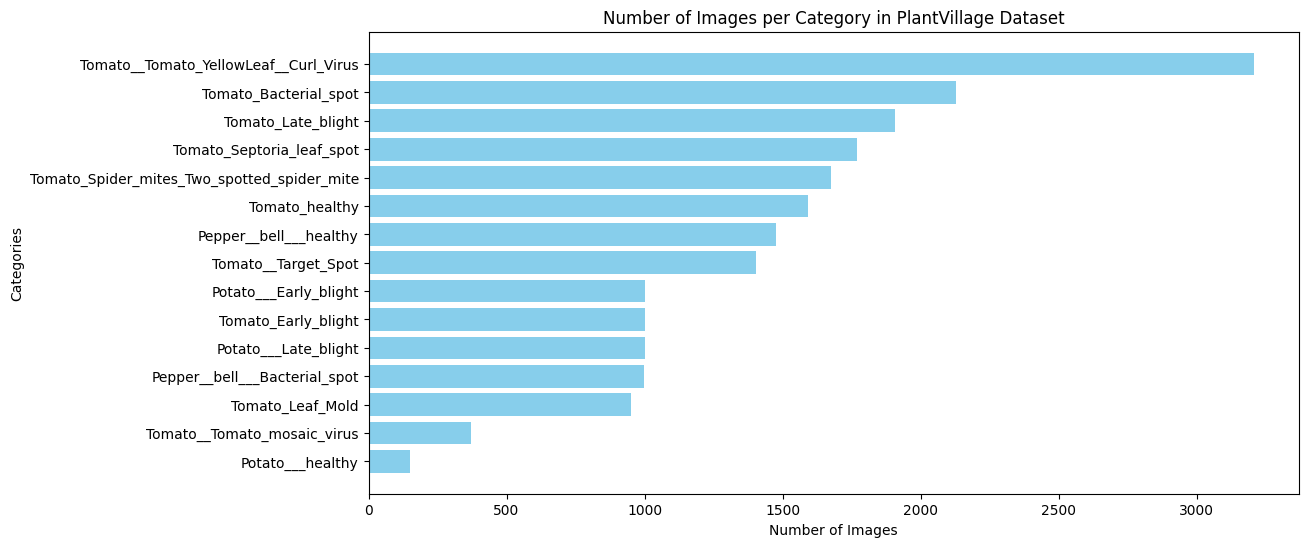

In [ ]:
import os
import matplotlib.pyplot as plt

dataset_path = "/content/PlantVillage"
categories = [
    'Tomato_Septoria_leaf_spot', 'Potato___Early_blight', 'Pepper__bell___healthy',
    'Tomato_healthy', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus',
    'Tomato_Late_blight', 'Tomato_Early_blight', 'Potato___healthy', 'Pepper__bell___Bacterial_spot',
    'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato_Bacterial_spot',
    'Potato___Late_blight', 'Tomato_Leaf_Mold'
]

category_counts = {}

for category in categories:
    class_path = os.path.join(dataset_path, category)

    # Count only image files
    if os.path.exists(class_path) and os.path.isdir(class_path):
        image_count = sum(1 for file in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, file)))
        category_counts[category] = image_count
    else:
        category_counts[category] = 0  # If folder doesn't exist

# Sort categories by count (optional)
category_counts = dict(sorted(category_counts.items(), key=lambda x: x[1], reverse=True))

# Plot the data
plt.figure(figsize=(12, 6))
plt.barh(list(category_counts.keys()), list(category_counts.values()), color='skyblue')
plt.xlabel("Number of Images")
plt.ylabel("Categories")
plt.title("Number of Images per Category in PlantVillage Dataset")
plt.gca().invert_yaxis()  # To display highest count on top
plt.show()

In [ ]:
import os
print(os.listdir("/content/PlantVillage/Tomato_Early_blight"))

['762585ed-e09c-43c8-8297-8b6ef503ecb0___RS_Erly.B 7420.JPG', 'de96e7a2-6de3-4699-9680-9eb4d4e215c8___RS_Erly.B 9445.JPG', '8714986a-ae97-489a-8259-67411bfa2379___RS_Erly.B 9400.JPG', '29f5538a-fda9-4040-81c2-02269a45ad68___RS_Erly.B 7670.JPG', '325b9138-a030-4156-ae85-20de17e89f7e___RS_Erly.B 7807.JPG', '6e673a0a-ad79-489d-bd0a-d96479fd81b5___RS_Erly.B 7441.JPG', '2ab7f21e-4a55-4895-acdb-5f161167a0f1___RS_Erly.B 8318.JPG', '7cd27862-7a89-4ffc-bc08-7dfbb24f76d9___RS_Erly.B 7560.JPG', '5d45c117-439e-454a-bc77-93a27ce98761___RS_Erly.B 7546.JPG', '422802e1-cee5-43b7-b735-7f90b5e5d4e2___RS_Erly.B 7349.JPG', '22b653c4-9e15-4081-8ece-9b5950a94120___RS_Erly.B 7814.JPG', 'ef1bea6d-41dd-4f88-9a5e-854abf1a5101___RS_Erly.B 9539.JPG', '011aa278-a39e-40b0-b6e4-2e2f835889f0___RS_Erly.B 8251.JPG', 'a98a655f-a2f5-44eb-a73b-edf25ca85921___RS_Erly.B 6351.JPG', 'c3e85d27-e5e0-4897-a039-22640e696184___RS_Erly.B 9459.JPG', '8e1c8815-49e0-4be6-a3a5-a426ab6b2445___RS_Erly.B 7822.JPG', 'd5bddab9-06bd-488f-a84

 **Class Imbalance Handling**
* **Data Augmentation**:

    Apply transformations like horizontal/vertical flips, rotations, zooms, and brightness adjustments to create synthetic variations of minority class images.

* **Oversampling/Undersampling**:

  Increase the number of minority class samples or reduce majority class samples to balance data distribution.

In [ ]:
import os
import cv2
import random
import numpy as np
import albumentations as A
from albumentations.core.composition import OneOf
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm

# Define dataset path
dataset_path = "/content/PlantVillage"

# List of categories that need augmentation (all after 'Tomato_Target_Spot')
categories = [
    'Potato___Early_blight', 'Tomato_Early_blight', 'Potato___Late_blight',
    'Pepper__bell___Bacterial_spot', 'Tomato_Leaf_Mold', 'Tomato__Tomato_mosaic_virus', 'Potato___healthy'
]

# Target images per class
TARGET_COUNT = 1500

# Augmentation pipeline using Albumentations
augment = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=20, p=0.7),
    A.RandomBrightnessContrast(p=0.5),
    A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),
    A.CLAHE(clip_limit=4.0, tile_grid_size=(8,8), p=0.3),
    ToTensorV2()
])

# Function to save augmented images
def save_augmented_image(image, save_path, count):
    aug_img = augment(image=image)["image"]
    aug_img = aug_img.permute(1, 2, 0).numpy()  # Convert back to OpenCV format
    cv2.imwrite(f"{save_path}/aug_{count}.jpg", aug_img * 255)

# Loop through each category
for category in categories:
    class_path = os.path.join(dataset_path, category)
    save_path = os.path.join(class_path, "augmented")

    # Create folder if not exists
    os.makedirs(save_path, exist_ok=True)

    # List all images in the class
    images = [img for img in os.listdir(class_path) if img.lower().endswith(('png', 'jpg', 'jpeg'))]

    # If no images found, skip augmentation
    if not images:
        print(f"⚠️ Warning: No images found in {category}. Skipping augmentation.")
        continue

    # Count existing images (original + augmented)
    total_images = len(images) + len(os.listdir(save_path))

    # Number of new images required
    extra_needed = TARGET_COUNT - total_images

    # If already sufficient images, skip augmentation
    if extra_needed <= 0:
        print(f"✅ {category} already has {total_images} images. Skipping augmentation.")
        continue

    print(f"📢 Augmenting {category}: Need {extra_needed} more images")

    # Generate augmented images
    for i in tqdm(range(extra_needed), desc=f"Augmenting {category}"):
        img_name = random.choice(images)
        img_path = os.path.join(class_path, img_name)

        # Read image
        img = cv2.imread(img_path)
        if img is None:
            print(f"⚠️ Skipping corrupted image: {img_name}")
            continue

        # Save augmented image
        save_augmented_image(img, save_path, i)

print("✅ Data augmentation complete!")

✅ Potato___Early_blight already has 1500 images. Skipping augmentation.
✅ Tomato_Early_blight already has 1500 images. Skipping augmentation.
✅ Potato___Late_blight already has 1500 images. Skipping augmentation.
✅ Pepper__bell___Bacterial_spot already has 1500 images. Skipping augmentation.
✅ Tomato_Leaf_Mold already has 1500 images. Skipping augmentation.
✅ Tomato__Tomato_mosaic_virus already has 1500 images. Skipping augmentation.
✅ Potato___healthy already has 1500 images. Skipping augmentation.
✅ Data augmentation complete!


<ipython-input-19-3c2f43f65edb>:27: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),


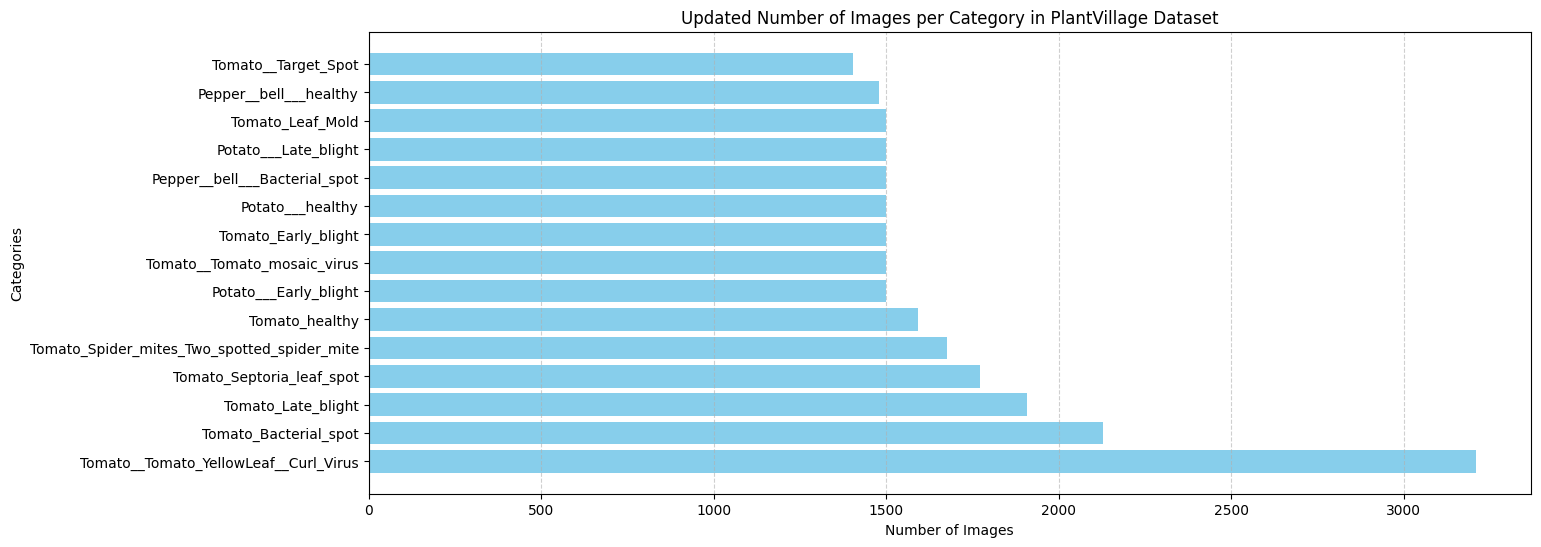

In [ ]:
import os
import matplotlib.pyplot as plt

# Define dataset path
dataset_path = "/content/PlantVillage"

# List of categories
categories = [
    'Tomato_Septoria_leaf_spot', 'Potato___Early_blight', 'Pepper__bell___healthy', 'Tomato_healthy',
    'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_Late_blight',
    'Tomato_Early_blight', 'Potato___healthy', 'Pepper__bell___Bacterial_spot',
    'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato_Bacterial_spot',
    'Potato___Late_blight', 'Tomato_Leaf_Mold'
]

# Store category names and image counts
category_counts = []

for category in categories:
    class_path = os.path.join(dataset_path, category)

    # Count images (original + augmented)
    num_images = len([img for img in os.listdir(class_path) if img.lower().endswith(('png', 'jpg', 'jpeg'))])

    augmented_path = os.path.join(class_path, "augmented")
    if os.path.exists(augmented_path):
        num_images += len([img for img in os.listdir(augmented_path) if img.lower().endswith(('png', 'jpg', 'jpeg'))])

    category_counts.append((category, num_images))

# Sort categories by image count
category_counts.sort(key=lambda x: x[1], reverse=True)

# Extract category names and counts
categories_sorted, counts_sorted = zip(*category_counts)

# Plot the updated graph
plt.figure(figsize=(15, 6))
plt.barh(categories_sorted, counts_sorted, color="skyblue")
plt.xlabel("Number of Images")
plt.ylabel("Categories")
plt.title("Updated Number of Images per Category in PlantVillage Dataset")
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.show()

In [ ]:
import os
import shutil

# Define the dataset root
dataset_path = "PlantVillage"

# Iterate through each class folder
for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)

    # Check if it's a directory (i.e., a class folder)
    if os.path.isdir(class_path):
        augmented_path = os.path.join(class_path, "augmented")

        # If "augmented" folder exists, move images
        if os.path.exists(augmented_path):
            print(f"📂 Moving images from: {augmented_path}")

            # Move all images from "augmented" to the main class folder
            for img in os.listdir(augmented_path):
                img_path = os.path.join(augmented_path, img)
                if img.endswith(('.png', '.jpg', '.jpeg')):  # Ensure only image files are moved
                    shutil.move(img_path, os.path.join(class_path, img))

            # Remove the empty "augmented" folder
            os.rmdir(augmented_path)
            print(f"✅ Removed empty folder: {augmented_path}")

print("🎯 All augmented images moved, and 'augmented' subfolders deleted successfully!")

📂 Moving images from: PlantVillage/Tomato_Early_blight/augmented
✅ Removed empty folder: PlantVillage/Tomato_Early_blight/augmented
📂 Moving images from: PlantVillage/Potato___Early_blight/augmented
✅ Removed empty folder: PlantVillage/Potato___Early_blight/augmented
📂 Moving images from: PlantVillage/Tomato_Leaf_Mold/augmented
✅ Removed empty folder: PlantVillage/Tomato_Leaf_Mold/augmented
📂 Moving images from: PlantVillage/Pepper__bell___Bacterial_spot/augmented
✅ Removed empty folder: PlantVillage/Pepper__bell___Bacterial_spot/augmented
📂 Moving images from: PlantVillage/Potato___Late_blight/augmented
✅ Removed empty folder: PlantVillage/Potato___Late_blight/augmented
📂 Moving images from: PlantVillage/Potato___healthy/augmented
✅ Removed empty folder: PlantVillage/Potato___healthy/augmented
📂 Moving images from: PlantVillage/Tomato__Tomato_mosaic_virus/augmented
✅ Removed empty folder: PlantVillage/Tomato__Tomato_mosaic_virus/augmented
🎯 All augmented images moved, and 'augmented' 

In [ ]:
import os

def print_directory_structure(root_dir, level=0):
    """ Recursively prints the directory structure and file counts. """
    if not os.path.exists(root_dir):
        print(f"❌ Path '{root_dir}' does not exist!")
        return

    # Iterate through the root directory
    for item in sorted(os.listdir(root_dir)):
        item_path = os.path.join(root_dir, item)

        # Check if it's a folder
        if os.path.isdir(item_path):
            num_files = len([f for f in os.listdir(item_path) if f.endswith(('.png', '.jpg', '.jpeg', '.PNG', '.JPG'))])
            print(" " * (level * 4) + f"📁 {item}: {num_files} images")

            # Recursively print subdirectories
            print_directory_structure(item_path, level + 1)

# Set the dataset directory
dataset_path = "PlantVillage"

# Print the directory structure
print(f"\n📂 Directory Structure of: {dataset_path}\n")
print_directory_structure(dataset_path)


📂 Directory Structure of: PlantVillage

📁 Pepper__bell___Bacterial_spot: 1500 images
📁 Pepper__bell___healthy: 1478 images
📁 Potato___Early_blight: 1500 images
📁 Potato___Late_blight: 1500 images
📁 Potato___healthy: 1500 images
📁 Tomato_Bacterial_spot: 2127 images
📁 Tomato_Early_blight: 1500 images
📁 Tomato_Late_blight: 1909 images
📁 Tomato_Leaf_Mold: 1500 images
📁 Tomato_Septoria_leaf_spot: 1771 images
📁 Tomato_Spider_mites_Two_spotted_spider_mite: 1676 images
📁 Tomato__Target_Spot: 1404 images
📁 Tomato__Tomato_YellowLeaf__Curl_Virus: 3208 images
📁 Tomato__Tomato_mosaic_virus: 1500 images
📁 Tomato_healthy: 1591 images


In [ ]:
import os
import shutil
import random

# Define paths
dataset_dir = "PlantVillage"
train_dir = "PlantVillage_Split/train"
test_dir = "PlantVillage_Split/test"

# Create directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Define split ratio
split_ratio = 0.8  # 80% train, 20% test

# Iterate over each class folder
for class_name in os.listdir(dataset_dir):
    class_path = os.path.join(dataset_dir, class_name)

    if os.path.isdir(class_path):  # Check if it's a folder
        images = os.listdir(class_path)
        random.shuffle(images)  # Shuffle for randomness

        split_index = int(len(images) * split_ratio)
        train_images, test_images = images[:split_index], images[split_index:]

        # Create class subdirectories
        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

        # Move files
        for img in train_images:
            shutil.copy(os.path.join(class_path, img), os.path.join(train_dir, class_name, img))
        for img in test_images:
            shutil.copy(os.path.join(class_path, img), os.path.join(test_dir, class_name, img))

print("Dataset successfully split into Train and Test sets!")

Dataset successfully split into Train and Test sets!


In [ ]:
import os

def check_directory_structure(root_dir):
    print(f"\n📂 Directory Structure of: {root_dir}\n")

    if not os.path.exists(root_dir):
        print(f"❌ Error: {root_dir} does not exist.")
        return

    for class_name in sorted(os.listdir(root_dir)):
        class_path = os.path.join(root_dir, class_name)
        if os.path.isdir(class_path):
            num_images = len(os.listdir(class_path))
            print(f"📁 {class_name}: {num_images} images")

# Paths to train and test directories
train_dir = "PlantVillage_Split/train"
test_dir = "PlantVillage_Split/test"

# Check train and test directory structures
check_directory_structure(train_dir)
check_directory_structure(test_dir)


📂 Directory Structure of: PlantVillage_Split/train

📁 Pepper__bell___Bacterial_spot: 1200 images
📁 Pepper__bell___healthy: 1182 images
📁 Potato___Early_blight: 1200 images
📁 Potato___Late_blight: 1200 images
📁 Potato___healthy: 1200 images
📁 Tomato_Bacterial_spot: 1701 images
📁 Tomato_Early_blight: 1200 images
📁 Tomato_Late_blight: 1527 images
📁 Tomato_Leaf_Mold: 1200 images
📁 Tomato_Septoria_leaf_spot: 1416 images
📁 Tomato_Spider_mites_Two_spotted_spider_mite: 1340 images
📁 Tomato__Target_Spot: 1123 images
📁 Tomato__Tomato_YellowLeaf__Curl_Virus: 2567 images
📁 Tomato__Tomato_mosaic_virus: 1200 images
📁 Tomato_healthy: 1272 images

📂 Directory Structure of: PlantVillage_Split/test

📁 Pepper__bell___Bacterial_spot: 300 images
📁 Pepper__bell___healthy: 296 images
📁 Potato___Early_blight: 300 images
📁 Potato___Late_blight: 300 images
📁 Potato___healthy: 300 images
📁 Tomato_Bacterial_spot: 426 images
📁 Tomato_Early_blight: 300 images
📁 Tomato_Late_blight: 382 images
📁 Tomato_Leaf_Mold: 30

In [ ]:
import tensorflow as tf

train_dir = "PlantVillage_Split/train"
test_dir = "PlantVillage_Split/test"
img_size = (224, 224)  # Adjust based on model

# Load images
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir, image_size=img_size, batch_size=32, label_mode="categorical"
)
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir, image_size=img_size, batch_size=32, label_mode="categorical"
)

Found 20527 files belonging to 15 classes.
Found 5137 files belonging to 15 classes.


 **Model Development**

**CNN Implementation**: Build Convolutional Neural Networks (CNNs) from scratch using frameworks like TensorFlow/Keras or PyTorch.

**Transfer Learning**: Utilize pre-trained models such as ResNet, VGG, or EfficientNet to leverage existing feature extraction capabilities.

**Ensemble Methods**: Combine multiple models' predictions for improved accuracy and robustness.

**Hyperparameter Tuning**: Optimize learning rate, batch size, and activation functions to enhance model performance

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3,3), activation="relu", input_shape=(224,224,3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation="relu"),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation="relu"),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(15, activation="softmax")  # 15 classes in your dataset
])

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 15)                  │           1,935 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,170,895 (42.61 MB)

 Trainable params: 11,170,895 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

model = Sequential([
    Conv2D(32, (3,3), activation="relu", input_shape=(224,224,3)),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation="relu"),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation="relu"),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(256, activation="relu"),  # Increased neurons
    Dropout(0.3),  # Reduced Dropout
    Dense(15, activation="softmax")  # 15 classes
])

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 222, 222, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 109, 109, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 52, 52, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │      22,151,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 15)                  │           3,855 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,249,423 (84.87 MB)

 Trainable params: 22,248,975 (84.87 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize images
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)


In [ ]:
from tensorflow.keras.optimizers import SGD

model.compile(
    loss="categorical_crossentropy",
    optimizer=SGD(learning_rate=0.01, momentum=0.9),
    metrics=["accuracy"]
)


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D

base_model = MobileNetV2(input_shape=(224,224,3), include_top=False, weights="imagenet")
base_model.trainable = False  # Freeze layers

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation="relu"),
    Dropout(0.3),
    Dense(15, activation="softmax")
])

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Epoch 1/30
642/642 ━━━━━━━━━━━━━━━━━━━━ 66s 76ms/step - accuracy: 0.4550 - loss: 1.7168 - val_accuracy: 0.7027 - val_loss: 0.9135
Epoch 2/30
642/642 ━━━━━━━━━━━━━━━━━━━━ 28s 43ms/step - accuracy: 0.6682 - loss: 0.9894 - val_accuracy: 0.7541 - val_loss: 0.7577
Epoch 3/30
642/642 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.7022 - loss: 0.8574 - val_accuracy: 0.7627 - val_loss: 0.7056
Epoch 4/30
642/642 ━━━━━━━━━━━━━━━━━━━━ 39s 42ms/step - accuracy: 0.7346 - loss: 0.7718 - val_accuracy: 0.7604 - val_loss: 0.7016
Epoch 5/30
642/642 ━━━━━━━━━━━━━━━━━━━━ 27s 43ms/step - accuracy: 0.7496 - loss: 0.7260 - val_accuracy: 0.7738 - val_loss: 0.6611
Epoch 6/30
642/642 ━━━━━━━━━━━━━━━━━━━━ 27s 43ms/step - accuracy: 0.7670 - loss: 0.6731 - val_accuracy: 0.7732 - val_loss: 0.6762
Epoch 7/30
642/642 ━━━━━━━━━━━━━━━━━━━━ 28s 43ms/step - accuracy: 0.7704 - loss: 0.6499 - val_accuracy: 0.7974 - val_loss: 0.5947
Epoch 8/30
642/642 ━━━━━━━━━━━━━━━━━━━━ 45s 49ms/step - accuracy: 0.7857 - loss: 0.6048 - 

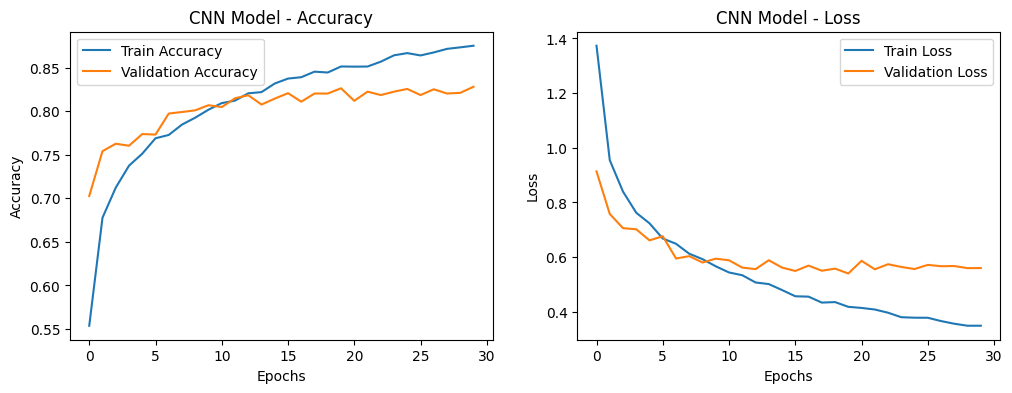

In [ ]:
import matplotlib.pyplot as plt

# Train the model and store the history
history = model.fit(train_data, validation_data=test_data, epochs=30)

# Check available history keys
print(history.history.keys())  # This should print available metrics

# Get the correct metric names
train_acc = history.history.get("accuracy") or history.history.get("categorical_accuracy") or history.history.get("sparse_categorical_accuracy")
val_acc = history.history.get("val_accuracy") or history.history.get("val_categorical_accuracy") or history.history.get("val_sparse_categorical_accuracy")

# Ensure metrics exist before plotting
if train_acc is None or val_acc is None:
    print("Error: Accuracy metrics not found in history. Check model compilation.")
else:
    # Plot Accuracy
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(train_acc, label="Train Accuracy")
    plt.plot(val_acc, label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("CNN Model - Accuracy")

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("CNN Model - Loss")

    plt.show()


In [ ]:
model.evaluate(test_data)

161/161 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - accuracy: 0.8285 - loss: 0.5513


[0.5596636533737183, 0.8281098008155823]

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

y_true = []
y_pred = []

for images, labels in test_data:
    preds = model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(np.argmax(labels.numpy(), axis=1))

print(classification_report(y_true, y_pred))

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━

In [ ]:
model.save("plant_disease_cnn.h5")
print("Model saved successfully!")

Model saved successfully!


In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model("plant_disease_cnn.h5")
print("Model loaded successfully!")

Model loaded successfully!


In [ ]:
for layer in model.layers:
    print(layer.name)

mobilenetv2_1.00_224
global_average_pooling2d
dense_4
dropout_2
dense_5


161/161 ━━━━━━━━━━━━━━━━━━━━ 52s 59ms/step


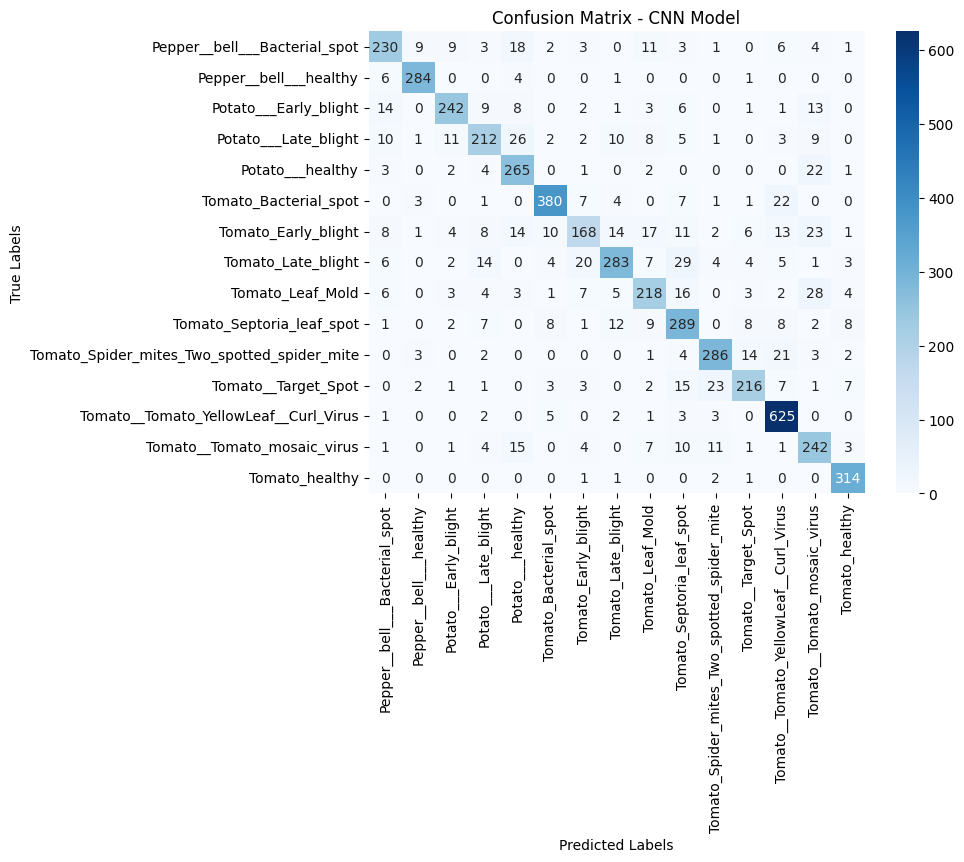

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

import numpy as np

# Extract images (X_test) and labels (y_test) from test dataset
X_test = []
y_test = []

for images, labels in test_data:
    X_test.append(images.numpy())   # Convert tensor to NumPy array
    y_test.append(labels.numpy())   # Convert labels to NumPy array

# Convert list to NumPy arrays
X_test = np.concatenate(X_test, axis=0)
y_test = np.concatenate(y_test, axis=0)

# Ensure X_test and y_test are defined
# If y_test is one-hot encoded, convert it to class labels
y_true = np.argmax(y_test, axis=1)  # True labels
y_pred_cnn = np.argmax(model.predict(X_test), axis=1)  # CNN model predictions

# Compute confusion matrix
cm_cnn = confusion_matrix(y_true, y_pred_cnn)
class_labels = train_data.class_names  # Extracts class names from dataset
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - CNN Model")
plt.show()

. **Model Explainability**

 **Grad-CAM (Gradient-weighted Class Activation Mapping)**:

* Visualize important regions in an
     image that influence the model's predictions.

*     Generate heatmaps to interpret model focus.

**Saliency Maps**:

*  Identify which image pixels contribute most to classification decisions.

**Feature Importance Analysis**:

*  Understand how different CNN layers extract features at various stages.



Found 5 images. Processing...
Images selected: ['/content/PlantVillage_Split/train/Pepper__bell___Bacterial_spot/aug_417.jpg', '/content/PlantVillage_Split/train/Pepper__bell___Bacterial_spot/aug_2.jpg', '/content/PlantVillage_Split/train/Pepper__bell___Bacterial_spot/aug_164.jpg', '/content/PlantVillage_Split/train/Pepper__bell___Bacterial_spot/aug_328.jpg', '/content/PlantVillage_Split/train/Pepper__bell___Bacterial_spot/aug_286.jpg']
Processing image: /content/PlantVillage_Split/train/Pepper__bell___Bacterial_spot/aug_417.jpg


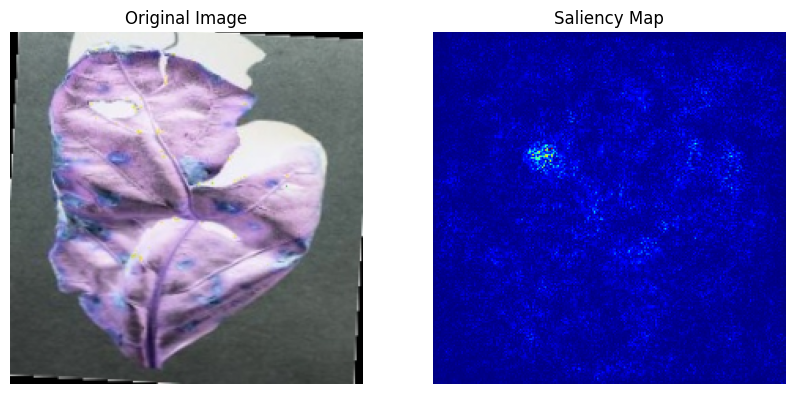

Processing image: /content/PlantVillage_Split/train/Pepper__bell___Bacterial_spot/aug_2.jpg


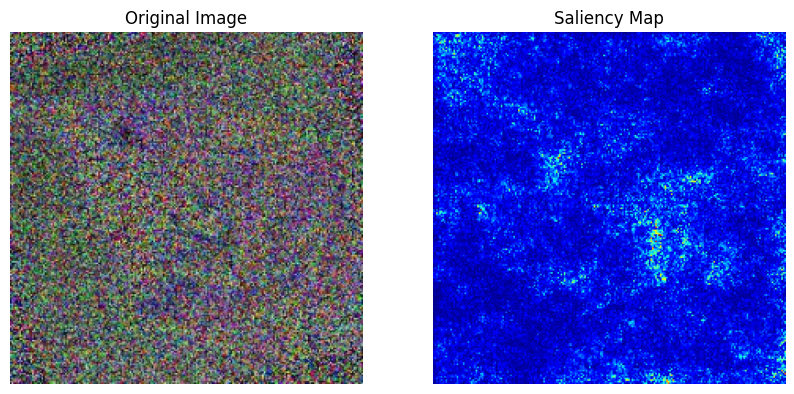

Processing image: /content/PlantVillage_Split/train/Pepper__bell___Bacterial_spot/aug_164.jpg


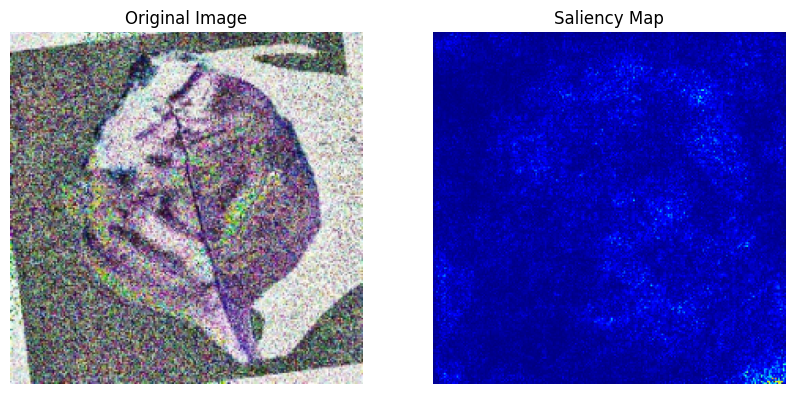

Processing image: /content/PlantVillage_Split/train/Pepper__bell___Bacterial_spot/aug_328.jpg


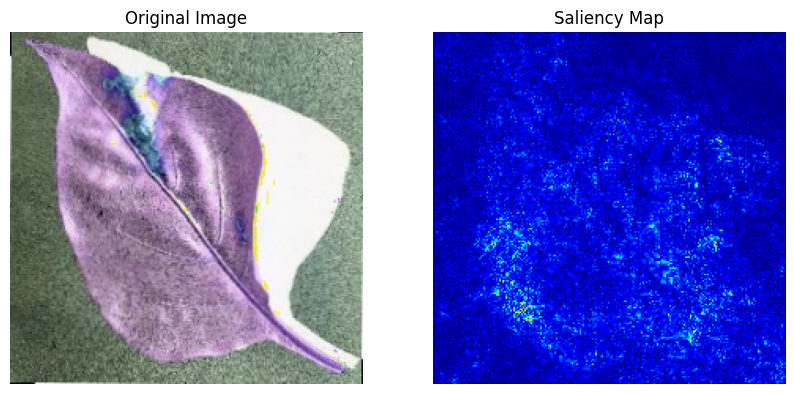

Processing image: /content/PlantVillage_Split/train/Pepper__bell___Bacterial_spot/aug_286.jpg


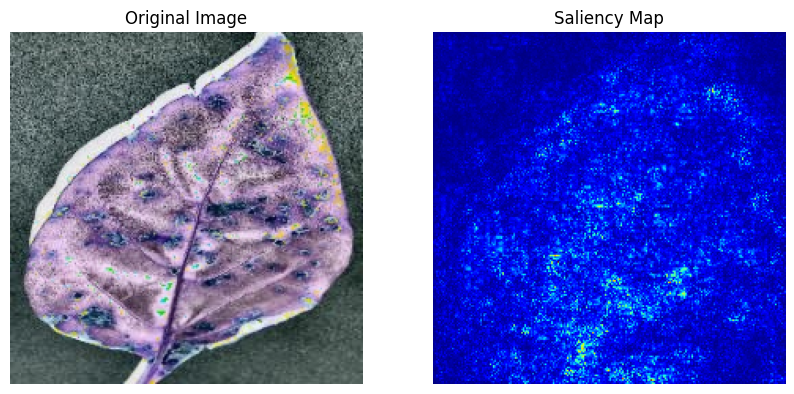

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import random

# Load your trained model
model_path = "plant_disease_cnn.h5"
if not os.path.exists(model_path):
    raise ValueError(f"Model file not found: {model_path}")

model = tf.keras.models.load_model(model_path)

# Function to preprocess an image
def preprocess_image(image_path, target_size=(224, 224)):
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Error loading image: {image_path}")  # Debugging
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target_size)
    img = img / 255.0  # Normalize pixel values
    img_array = np.expand_dims(img, axis=0)  # Add batch dimension
    return tf.convert_to_tensor(img_array, dtype=tf.float32), img

# Get random images from a directory
def get_random_images(image_dir, num_images=5):
    if not os.path.exists(image_dir) or len(os.listdir(image_dir)) == 0:
        raise ValueError(f"No images found in directory: {image_dir}")  # Debugging

    all_images = [os.path.join(image_dir, img) for img in os.listdir(image_dir) if img.endswith((".jpg", ".png"))]

    if len(all_images) == 0:
        raise ValueError("No valid images found in the directory")  # Debugging

    return random.sample(all_images, min(num_images, len(all_images)))

# Directory containing images (Update this path)
image_dir = "/content/PlantVillage_Split/train/Pepper__bell___Bacterial_spot"  # Update path

# Get 5-10 random images
num_images = 5
image_paths = get_random_images(image_dir, num_images)

print(f"Found {len(image_paths)} images. Processing...")
print("Images selected:", image_paths)  # Debugging

# Generate saliency maps for each image
for image_path in image_paths:
    print(f"Processing image: {image_path}")  # Debugging

    img_tensor, original_img = preprocess_image(image_path)

    # Get model predictions
    predictions = model(img_tensor)
    class_idx = tf.argmax(predictions[0])  # Select the predicted class

    # Compute gradients of the class w.r.t the input image
    with tf.GradientTape() as tape:
        tape.watch(img_tensor)
        predictions = model(img_tensor)
        loss = predictions[:, class_idx]  # Focus on the predicted class

    # Get the gradients
    grads = tape.gradient(loss, img_tensor)

    # Compute the absolute values and take the maximum along the color channels
    saliency = tf.reduce_max(tf.abs(grads), axis=-1)[0].numpy()

    # Normalize for visualization
    saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min())

    # Display the original image and the saliency map
    plt.figure(figsize=(10, 5))

    # Original Image
    plt.subplot(1, 2, 1)
    plt.imshow(original_img)
    plt.axis("off")
    plt.title("Original Image")

    # Saliency Map
    plt.subplot(1, 2, 2)
    plt.imshow(saliency, cmap="jet")
    plt.axis("off")
    plt.title("Saliency Map")

    plt.show(block=True)  # Ensure images are displayed

In [ ]:
import tensorflow as tf

train_dir = "PlantVillage_Split/train"
test_dir = "PlantVillage_Split/test"
img_size = (224, 224)  # Adjust based on model

# Load images
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir, image_size=img_size, batch_size=32, label_mode="categorical"
)
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir, image_size=img_size, batch_size=32, label_mode="categorical"
)

Found 20527 files belonging to 15 classes.
Found 5137 files belonging to 15 classes.


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define a Custom ResNet Model
def build_resnet(input_shape=(224, 224, 3), num_classes=2, use_sparsity=False):
    base_model = tf.keras.applications.ResNet50(
        weights="imagenet",  # Use pretrained weights for better performance
        input_shape=input_shape,
        include_top=False
    )

    base_model.trainable = False  # Freeze base layers initially

    model = models.Sequential([
        layers.Input(shape=input_shape),

        # Data Augmentation (Optional)
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.2),

        base_model,
        layers.BatchNormalization(),
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax")
    ])

    return model

# Detect Number of Classes
num_classes = len(train_data.class_names)  # Ensure train_data is defined

# Check if labels are sparse or one-hot encoded
use_sparsity = False  # Change to True if using sparse labels

# Create Model
input_shape = (224, 224, 3)
resnet_model = build_resnet(input_shape, num_classes, use_sparsity)

# Compile the Model
resnet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss="sparse_categorical_crossentropy" if use_sparsity else "categorical_crossentropy",
    metrics=["accuracy"]
)

# Print Model Summary
resnet_model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation (RandomRotation)     │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 7, 7, 2048)          │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 15)                  │           3,855 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,124,303 (92.03 MB)

 Trainable params: 532,495 (2.03 MB)

 Non-trainable params: 23,591,808 (90.00 MB)

In [ ]:
history = resnet_model.fit(train_data, epochs=10, validation_data=test_data)

Epoch 1/10
642/642 ━━━━━━━━━━━━━━━━━━━━ 123s 171ms/step - accuracy: 0.4854 - loss: 1.7213 - val_accuracy: 0.8223 - val_loss: 0.6031
Epoch 2/10
642/642 ━━━━━━━━━━━━━━━━━━━━ 134s 164ms/step - accuracy: 0.7855 - loss: 0.6961 - val_accuracy: 0.8596 - val_loss: 0.4398
Epoch 3/10
642/642 ━━━━━━━━━━━━━━━━━━━━ 143s 166ms/step - accuracy: 0.8293 - loss: 0.5332 - val_accuracy: 0.8709 - val_loss: 0.3805
Epoch 4/10
642/642 ━━━━━━━━━━━━━━━━━━━━ 142s 165ms/step - accuracy: 0.8534 - loss: 0.4519 - val_accuracy: 0.8865 - val_loss: 0.3359
Epoch 5/10
642/642 ━━━━━━━━━━━━━━━━━━━━ 142s 166ms/step - accuracy: 0.8681 - loss: 0.4033 - val_accuracy: 0.8935 - val_loss: 0.3128
Epoch 6/10
642/642 ━━━━━━━━━━━━━━━━━━━━ 142s 166ms/step - accuracy: 0.8775 - loss: 0.3675 - val_accuracy: 0.8970 - val_loss: 0.2961
Epoch 7/10
642/642 ━━━━━━━━━━━━━━━━━━━━ 142s 166ms/step - accuracy: 0.8909 - loss: 0.3358 - val_accuracy: 0.9054 - val_loss: 0.2769
Epoch 8/10
642/642 ━━━━━━━━━━━━━━━━━━━━ 142s 166ms/step - accuracy: 0.8921 -

In [ ]:
resnet_model.save("resnet_model.h5")

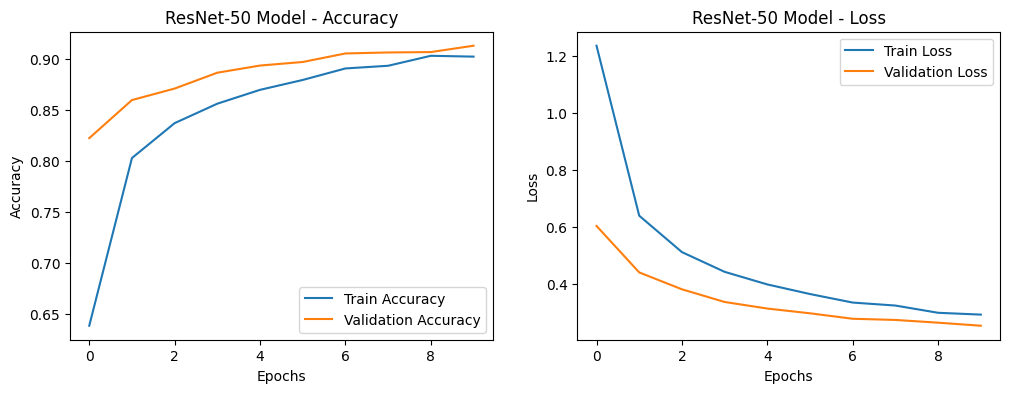

In [ ]:
# Extract history from ResNet-50 training
history_resnet = resnet_model.history

# Plot Accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_resnet.history["accuracy"], label="Train Accuracy")
plt.plot(history_resnet.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("ResNet-50 Model - Accuracy")

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_resnet.history["loss"], label="Train Loss")
plt.plot(history_resnet.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("ResNet-50 Model - Loss")

plt.show()

**Performance Evaluation**

* Accuracy, Precision, Recall, and F1-score:

   *    Evaluate overall and per-class model performance.

**Confusion Matrices**:

* Analyze misclassification patterns to improve model reliability.

**Loss & Accuracy Visualization**:

*    Track model performance across epochs using training/validation loss curves.

**Ablation Studies**:

* Experiment with different architectures, augmentations, and hyperparameters to determine what contributes most to performance

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

y_true = []
y_pred = []

for images, labels in test_data:
    preds = resnet_model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(np.argmax(labels.numpy(), axis=1))

print(classification_report(y_true, y_pred))

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

Found 5137 images belonging to 15 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


161/161 ━━━━━━━━━━━━━━━━━━━━ 26s 142ms/step


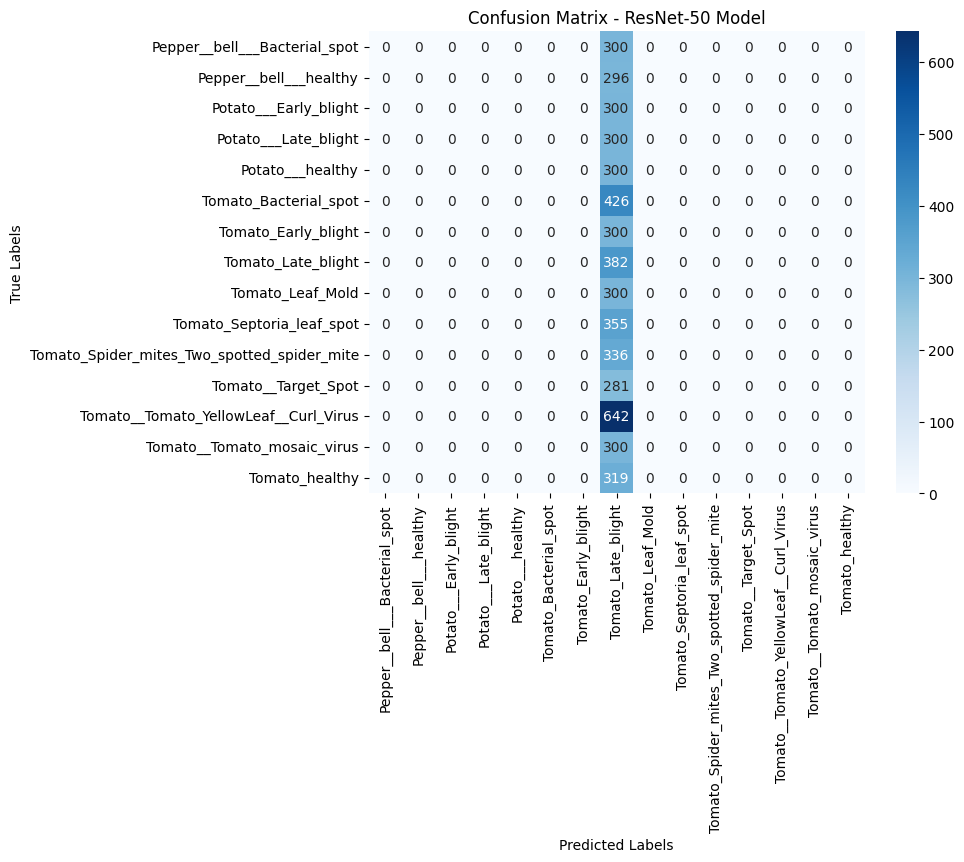

In [ ]:
import seaborn as sns
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Load test dataset
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0 / 255)

test_data = test_datagen.flow_from_directory(
    "/content/PlantVillage_Split/test",
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",  # Ensure consistency with training data
    shuffle=False
)

# Get true labels
y_true = test_data.classes  # Directly extract class indices

# Get model predictions
y_pred_proba = resnet_model.predict(test_data)  # Predict on the generator
y_pred = np.argmax(y_pred_proba, axis=1)  # Convert softmax probabilities to class labels

# Compute confusion matrix
cm_resnet = confusion_matrix(y_true, y_pred)

# Extract class labels
class_labels = list(test_data.class_indices.keys())

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_resnet, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - ResNet-50 Model")
plt.show()

In [ ]:
print(resnet_model.input_shape)


(None, 224, 224, 3)


Found 5137 images belonging to 15 classes.
102967424/102967424 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


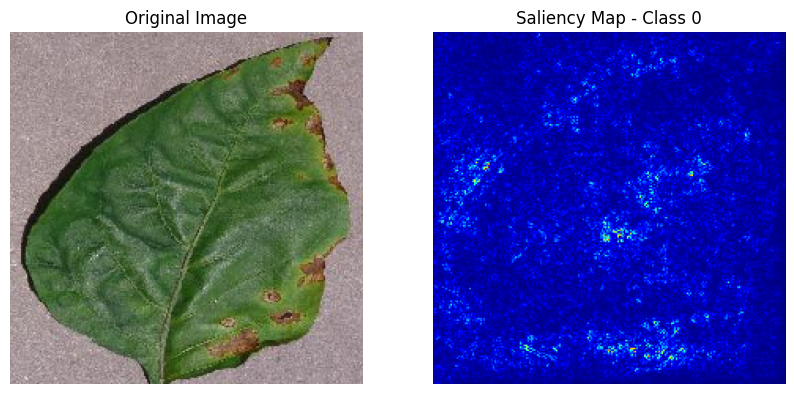

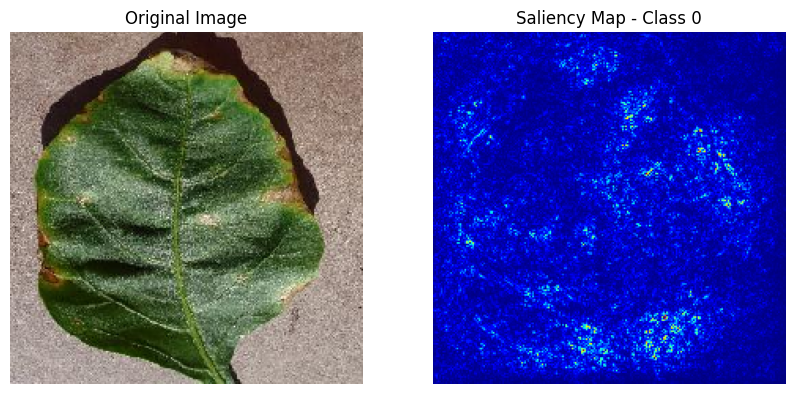

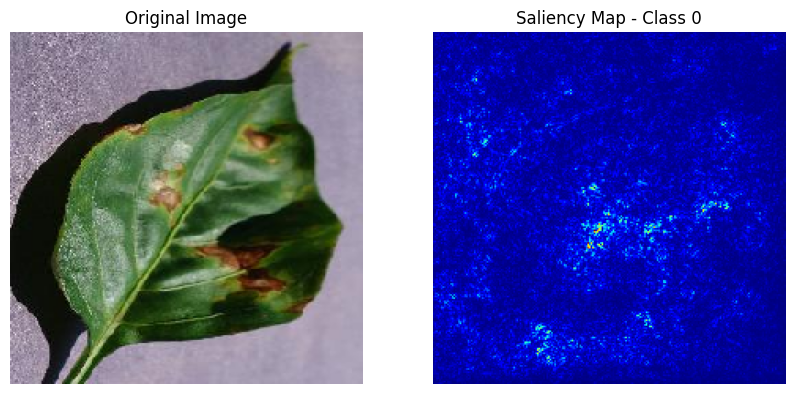

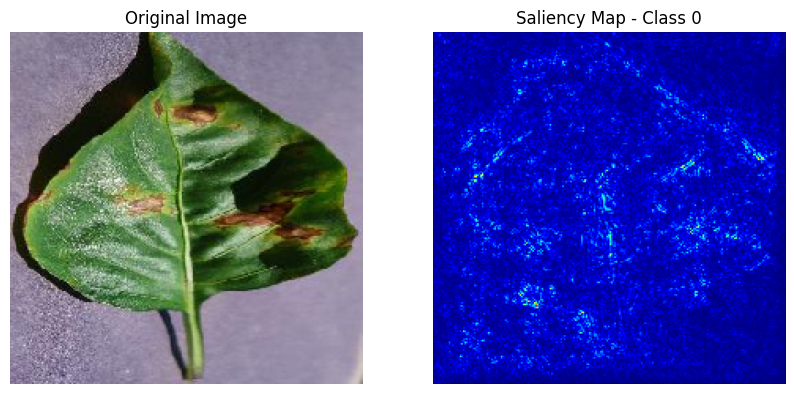

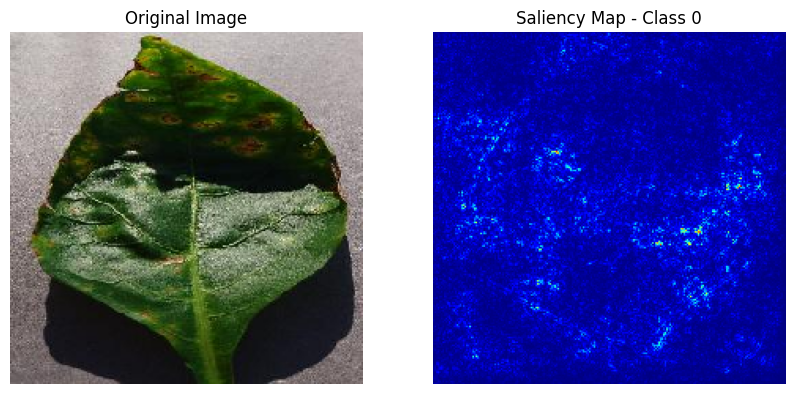

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Load test dataset
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0 / 255)

test_data = test_datagen.flow_from_directory(
    "/content/PlantVillage_Split/test",
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",  # Change to "sparse" if labels are integers
    shuffle=False
)

# Load pre-trained model (Ensure it's defined)
model = tf.keras.applications.ResNet50(weights="imagenet")  # Change to your trained model

# Function to generate saliency map
def compute_saliency_map(resnet_model, image, class_index):
    image = tf.convert_to_tensor(image, dtype=tf.float32)  # Ensure it's a tensor
    image = tf.expand_dims(image, axis=0)  # Add batch dimension

    with tf.GradientTape() as tape:
        tape.watch(image)
        predictions = resnet_model(image)
        loss = predictions[:, class_index]  # Target class score

    # Compute gradients
    grads = tape.gradient(loss, image)
    saliency = tf.reduce_max(tf.abs(grads), axis=-1)[0]  # Take max gradient across channels

    return saliency.numpy()

# Function to plot saliency map
def plot_saliency(image, saliency, title="Saliency Map"):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(image)  # Image should be in correct format
    ax[0].axis("off")
    ax[0].set_title("Original Image")

    ax[1].imshow(saliency, cmap="jet")
    ax[1].axis("off")
    ax[1].set_title(title)

    plt.show()

# Select random images from test dataset
num_images = 5  # Change this to 10 if needed

# Fetch images from dataset properly
for _ in range(num_images):
    image_batch, label_batch = next(test_data)  # ✅ Correct
    image = image_batch[0]  # Select first image from batch
    label = label_batch[0]  # Select corresponding label
    class_index = np.argmax(label)  # Get predicted class

    saliency = compute_saliency_map(model, image, class_index)
    plot_saliency(image, saliency, title=f"Saliency Map - Class {class_index}")